In [231]:
from gurobipy import Model, GRB, quicksum
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx  
import random
import numpy as np
import pandas as pd
from scipy.stats import norm

### **Arc Capacity Distribution**
Assume that the correlation among all arc capacities is 0.5

In [232]:
# Set arc information
arc_info = {
    "Arc #": ["1, 2", "3, 4", "5, 6", "7, 8", "9, 10"],
    "Lower bound": [10, 10, 5, 10, 10],
    "Upper bound": [20, 20, 10, 20, 20],
}
arc_df = pd.DataFrame(arc_info)

# Set correlation matrix: Correlation between arcs set to 0.5
num_arcs = len(arc_df)
corr_matrix = np.full((num_arcs, num_arcs), 0.5)  
np.fill_diagonal(corr_matrix, 1) 

# 1. Generate standard normal samples
num_samples = 5000
mean = np.zeros(num_arcs)
std_normal_samples = np.random.multivariate_normal(mean, corr_matrix, size=num_samples)

# 2. Transform to uniform distribution
uniform_samples = np.zeros_like(std_normal_samples)
for i in range(num_arcs):
    lower = arc_df.loc[i, "Lower bound"]
    upper = arc_df.loc[i, "Upper bound"]
    uniform_samples[:, i] = lower + (upper - lower) * norm.cdf(std_normal_samples[:, i])

# 3. Calculate mean and standard deviation for each arc
means = uniform_samples.mean(axis=0)
std_devs = uniform_samples.std(axis=0)

# Organize results into a DataFrame
results = pd.DataFrame({
    "Arc #": arc_df["Arc #"],
    "Mean": means,
    "Standard Deviation": std_devs,
})

# Print results
print(results)

   Arc #       Mean  Standard Deviation
0   1, 2  15.038163            2.875233
1   3, 4  15.013456            2.844583
2   5, 6   7.499632            1.436385
3   7, 8  14.987219            2.898583
4  9, 10  15.033675            2.869580


### **MCNF System Function**

Gurobi solver

In [233]:
def MCNF_systemfunc(comps_st, edges, arcs, arc_capacity, demand, arc_distance, max_distance):
    from gurobipy import Model, GRB, quicksum

    # Create Gurobi model
    model = Model("Network Flow Optimization")

    # Define variables
    flow = {}
    unmet_demand = {}
    for k, info in demand.items():
        unmet_demand[k] = model.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"unsatisfied_{k}")
        for i, j in arcs:
            # Determine capacity based on component state
            capacity = arc_capacity.get((i, j), 0) * comps_st[arcs.index((i, j))]
            flow[k, i, j] = model.addVar(lb=0, ub=capacity, vtype=GRB.CONTINUOUS, name=f"flow_{k}_{i}_{j}")

    # Objective function: Minimize the percentage of unmet demand relative to total demand
    total_demand = sum(info['amount'] for info in demand.values())
    model.setObjective(
        (quicksum(unmet_demand[k] for k in demand) / total_demand) * 100, GRB.MINIMIZE
    )
    
    # Extract all nodes from edge values
    nodes = set(node for edge in edges.values() for node in edge)

    # Constraint 1: Flow conservation
    for k, info in demand.items():
        origin = info['origin']
        destination = info['destination']
        amount = info['amount']
        for node in nodes: 
            inflow = quicksum(flow[k, i, j] for i, j in arcs if j == node)
            outflow = quicksum(flow[k, i, j] for i, j in arcs if i == node)
            if node == origin:
                model.addConstr(outflow - inflow == amount - unmet_demand[k])
            elif node == destination:
                model.addConstr(outflow - inflow == - amount + unmet_demand[k])
            else:
                model.addConstr(outflow - inflow == 0)

    # Constraint 2: Arc capacity limits
    for i, j in arcs:
        model.addConstr(quicksum(flow[k, i, j] for k in demand) <= arc_capacity.get((i, j), 0))

    # Constraint 3: Distance limits
    for k, info in demand.items():
        origin = info['origin']
        distance_expr = quicksum(arc_distance.get((i, j), 0) * flow[k, i, j] for i, j in arcs)
        total_flow = quicksum(flow[k, i, j] for i, j in arcs if i == origin)
        model.addConstr(distance_expr <= max_distance * total_flow)

    # Perform optimization
    model.optimize()

    # Process results
    if model.status == GRB.OPTIMAL:
        unmet_demand_percentage = model.objVal 
        flows = {
            k: {arc: flow[k, arc[0], arc[1]].X for arc in arcs} for k in demand
        }
        return unmet_demand_percentage, flows
    else:
        return None, None

### **Network Topology**
Generate Random Arc Capacity Value


Commodity: k1
  Shortest distance: 28.28 km
  Maximum allowable time: 17.39 minutes
  Maximum allowable distance: 43.18 km

Commodity: k2
  Shortest distance: 20.0 km
  Maximum allowable time: 14.05 minutes
  Maximum allowable distance: 34.90 km

Commodity: k3
  Shortest distance: 14.14 km
  Maximum allowable time: 11.69 minutes
  Maximum allowable distance: 29.04 km

Commodity: k4
  Shortest distance: 14.14 km
  Maximum allowable time: 11.69 minutes
  Maximum allowable distance: 29.04 km

Commodity: k5
  Shortest distance: 28.28 km
  Maximum allowable time: 17.39 minutes
  Maximum allowable distance: 43.18 km

Commodity: k6
  Shortest distance: 20.0 km
  Maximum allowable time: 14.05 minutes
  Maximum allowable distance: 34.90 km

Commodity: k7
  Shortest distance: 14.14 km
  Maximum allowable time: 11.69 minutes
  Maximum allowable distance: 29.04 km

Commodity: k8
  Shortest distance: 14.14 km
  Maximum allowable time: 11.69 minutes
  Maximum allowable distance: 29.04 km


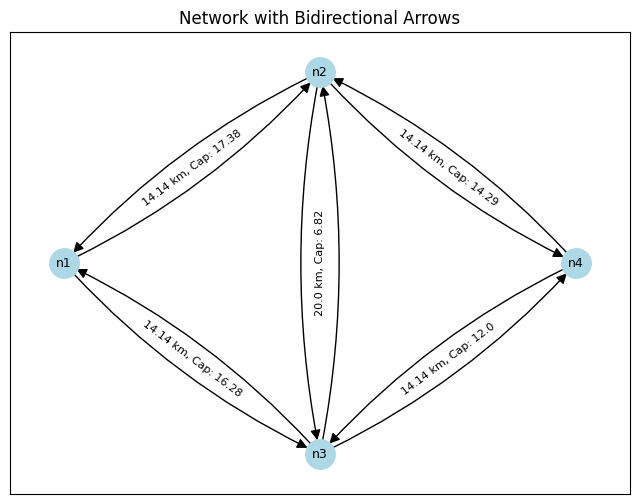


Edge Information:
e1 (n1 -> n2):
  Distance: 14.14 km
  Capacity: 17.38
e2 (n2 -> n1):
  Distance: 14.14 km
  Capacity: 17.38
e3 (n1 -> n3):
  Distance: 14.14 km
  Capacity: 16.28
e4 (n3 -> n1):
  Distance: 14.14 km
  Capacity: 16.28
e5 (n2 -> n3):
  Distance: 20.0 km
  Capacity: 6.82
e6 (n3 -> n2):
  Distance: 20.0 km
  Capacity: 6.82
e7 (n2 -> n4):
  Distance: 14.14 km
  Capacity: 14.29
e8 (n4 -> n2):
  Distance: 14.14 km
  Capacity: 14.29
e9 (n3 -> n4):
  Distance: 14.14 km
  Capacity: 12.0
e10 (n4 -> n3):
  Distance: 14.14 km
  Capacity: 12.0


In [234]:
# Node and edge data
nodes = {
    "n1": (0, 0),
    "n2": (10, 10),
    "n3": (10, -10),
    "n4": (20, 0)
}

edges = {  
    "e1": ("n1", "n2"),   
    "e2": ("n2", "n1"),   
    "e3": ("n1", "n3"),   
    "e4": ("n3", "n1"),   
    "e5": ("n2", "n3"),   
    "e6": ("n3", "n2"),   
    "e7": ("n2", "n4"),   
    "e8": ("n4", "n2"),   
    "e9": ("n3", "n4"),   
    "e10": ("n4", "n3")   
}



# Euclidean distance function
def euclidean_distance(node1, node2):
    x1, y1 = nodes[node1]
    x2, y2 = nodes[node2]
    return round(((x2 - x1)**2 + (y2 - y1)**2)**0.5, 2)



# Generate random capacities
# Arc parameters: Mean and Standard Deviation 
arc_params = {
    "dist1": (15.053352, 2.854469),
    "dist2": (15.048917, 2.882340),
    "dist3": (7.520903, 1.452187),
    "dist4": (15.041577, 2.886459),
    "dist5": (15.052937, 2.912252)
}

def generate_arc_capacities(arc_params):   
    arc_capacities = {}   
    for dist_name, (mean, std) in arc_params.items():   
        lower_bound = mean - (std * np.sqrt(3))   
        upper_bound = mean + (std * np.sqrt(3))   
        arc_capacities[dist_name] = round(np.random.uniform(lower_bound, upper_bound), 2)  
    return arc_capacities   

arc_capacity = generate_arc_capacities(arc_params)

# Assign capacities to edges based on distributions
edge_capacity_map = {
    "dist1": ["e1", "e2"],
    "dist2": ["e3", "e4"],
    "dist3": ["e5", "e6"],
    "dist4": ["e7", "e8"],
    "dist5": ["e9", "e10"]
}

edge_capacities = {}
for dist_name, edge_list in edge_capacity_map.items():
    for edge_name in edge_list:
        edge_capacities[edge_name] = arc_capacity[dist_name]



# Compute distances
arc_distance = {edge_name: euclidean_distance(u, v) for edge_name, (u, v) in edges.items()}   



# Create the graph
G = nx.DiGraph()
for node, position in nodes.items():
    G.add_node(node, pos=position)

for edge_name, (u, v) in edges.items():   
    distance = arc_distance[edge_name]   
    capacity = edge_capacities[edge_name]  # edge_capacities에서 용량 값을 가져옴
    G.add_edge(u, v, weight=distance, capacity=capacity)   



# Calculate maximum allowable distance
# Demand data
demand = {
    'k1': {'origin': 'n1', 'destination': 'n4', 'amount': 18},
    'k2': {'origin': 'n2', 'destination': 'n3', 'amount': 8},
    'k3': {'origin': 'n1', 'destination': 'n3', 'amount': 11},
    'k4': {'origin': 'n3', 'destination': 'n4', 'amount': 6},
    'k5': {'origin': 'n4', 'destination': 'n1', 'amount': 10},
    'k6': {'origin': 'n3', 'destination': 'n2', 'amount': 4},
    'k7': {'origin': 'n3', 'destination': 'n1', 'amount': 11},
    'k8': {'origin': 'n4', 'destination': 'n3', 'amount': 8}
}

# Maximum allowable delay time 6 minutes / average velocity 149 km/h
avg_velo = 149
for commodity, info in demand.items():
    shortest_distance = nx.shortest_path_length(G, source=info['origin'], target=info['destination'], weight='weight')
    max_allowable_time = (shortest_distance * 60) / avg_velo + 6  # 6 minutes extra
    max_distance = max_allowable_time * avg_velo / 60

    print(f"\nCommodity: {commodity}")
    print(f"  Shortest distance: {shortest_distance} km")
    print(f"  Maximum allowable time: {max_allowable_time:.2f} minutes")
    print(f"  Maximum allowable distance: {max_distance:.2f} km")



# Plot the network
plt.figure(figsize=(8, 6))
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx_nodes(G, pos, node_size=450, node_color="lightblue")
nx.draw_networkx_edges(
    G, pos,
    edgelist=list(edges.values()),  
    arrowstyle='-|>',
    arrowsize=15,
    connectionstyle='arc3,rad=0.1',
    min_target_margin=10,
    min_source_margin=10
)
edge_labels = {(u, v): f"{arc_distance[edge_name]} km, Cap: {edge_capacities[edge_name]}" 
               for edge_name, (u, v) in edges.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5)
nx.draw_networkx_labels(G, pos, font_size=9)
plt.title("Network with Bidirectional Arrows")
plt.show()



# Print edge information
print("\nEdge Information:")
for edge_name, (u, v) in edges.items():
    edge_data = G.get_edge_data(u, v) 
    distance = edge_data['weight']
    capacity = edge_data['capacity']
    print(f"{edge_name} ({u} -> {v}):")
    print(f"  Distance: {distance} km")
    print(f"  Capacity: {capacity}")


In [235]:
comps_st = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1}  #// FIXME: OuterLoop MCS

# Operate MCNF system function
unmet_percentage, flows = MCNF_systemfunc(
    comps_st=comps_st,
    edges=edges,
    arcs=arcs,
    arc_capacity=arc_capacity,
    demand = demand,
    arc_distance=arc_distance,
    max_distance=max_distance
)

if unmet_percentage is not None:
    print(f"Unmet Demand Percentage: {unmet_percentage:.2f}%")
    print("Flow Allocation:")
    for k, flow_dict in flows.items():
        print(f"  Commodity {k}:")
        for arc, flow_value in flow_dict.items():
            if flow_value > 0:
                print(f"    Flow on {arc}: {flow_value:.2f}")
else:
    print("Optimization failed or infeasible.")

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 5 3600XT 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 50 rows, 88 columns and 96 nonzeros
Model fingerprint: 0xbb28d8e9
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 2e+01]
Presolve removed 50 rows and 88 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.000000000e+02
Unmet Demand Percentage: 100.00%
Flow Allocation:
  Commodity k1:
  Commodity k2:
  Commodity k3:
  Commodity k4:
  Commodity k5:
  Commodity k6:
  Commodity k7:
  Commodity k8:
